In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torchinfo import summary
from tqdm.auto import tqdm
import torch.optim as optim
import pickle

path = "Data"
labelFile = "labels.csv"
BATCH_SIZE = 20
epochs = 1
steps_per_epoch = 2000
imageDimensions = (32,32,3)
test_ratio = 0.2
validation_ratio = 0.2

#import images

cnt = 0
images = []
classno = []
list_data = os.listdir(path)
print(len(list_data))
no_of_classes = len(list_data)

for i in range(no_of_classes):
    pic_list = os.listdir(path+"/"+str(cnt))
    for pic in pic_list:
        pic_path = path+"/"+str(cnt)+"/"+pic
        img = cv2.imread(pic_path)
        images.append(img)
        classno.append(cnt)
    print(cnt)
    cnt += 1

images = np.array(images)
classno = np.array(classno)
print(images.shape)
print(classno.shape)

#split data
X_train, X_test, y_train, y_test = train_test_split(images, classno, test_size=test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

c:\Users\yash jain\Desktop\ml project\trafffic sign detector\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
(34796, 32, 32, 3)
(34796,)
(22268, 32, 32, 3)
(6960, 32, 32, 3)
(5568, 32, 32, 3)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data = pd.read_csv(labelFile)
print(data.shape)
print(data.head())

(43, 2)
   ClassId                  Name
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


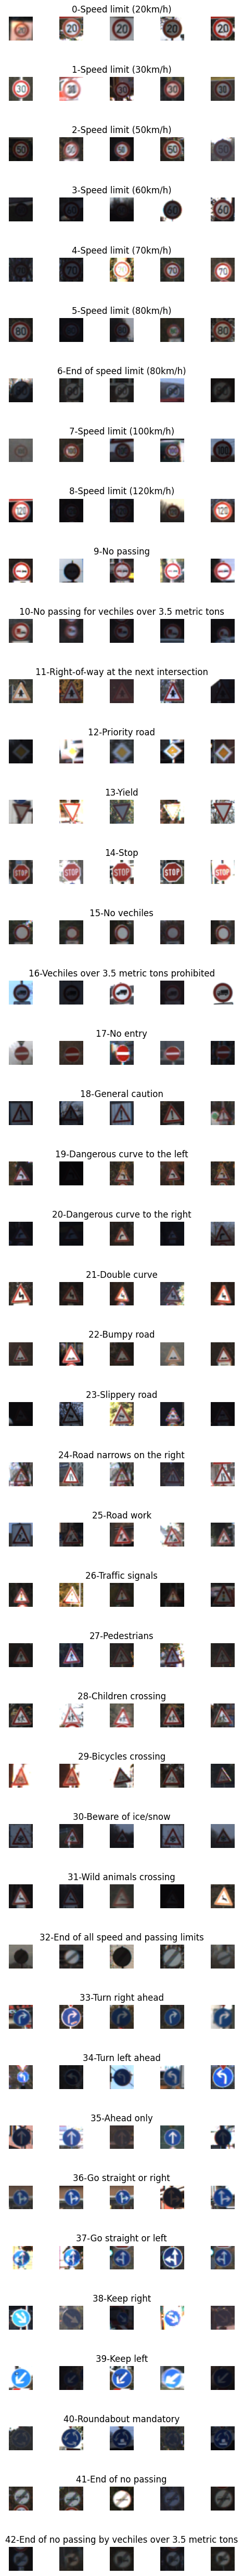

In [4]:
num_of_samples = []
cols = 5
num_classes = no_of_classes

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[np.random.randint(0,len(x_selected)) - 1,:,:], cmap="gray")
        axs[j][i].axis("off")
        if i==2:
            axs[j][i].set_title(str(j)+ "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[118, 1255, 1274, 805, 1157, 1035, 228, 846, 819, 845, 1121, 732, 1192, 1244, 447, 352, 233, 630, 708, 115, 195, 172, 201, 287, 156, 876, 361, 138, 327, 154, 250, 455, 126, 400, 232, 665, 210, 122, 1177, 175, 181, 129, 123]


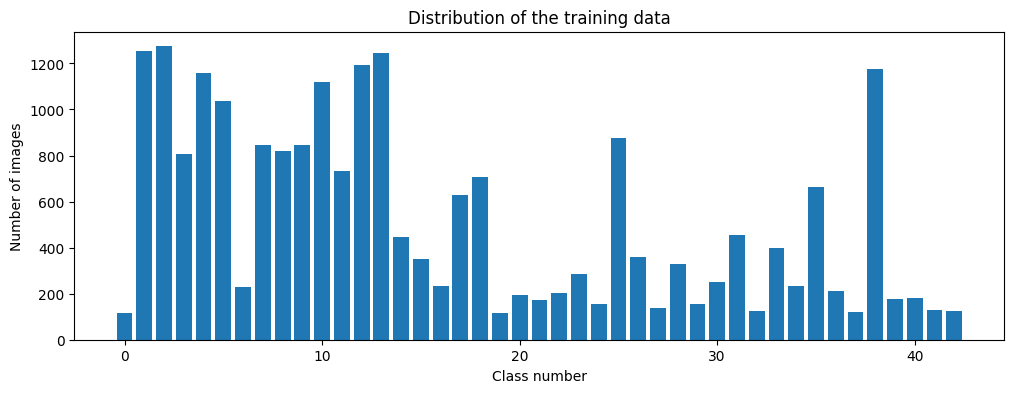

In [5]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes), num_of_samples)
plt.title("Distribution of the training data")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [6]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing,X_test)))


In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

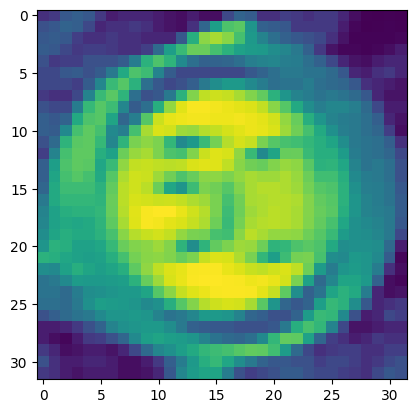

In [8]:
plt.imshow(X_train[0])

In [9]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ),
    transforms.ToTensor()
])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy.ndarray): Image data (N, H, W, C).
            labels (numpy.ndarray): Corresponding labels (N,).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert NumPy image (H, W, C) to PIL image for transformation
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
X_train_dataset = CustomDataset(X_train, y_train, transform=data_transforms)
X_val_dataset = CustomDataset(X_val, y_val,transform=data_transforms)
X_test_dataset = CustomDataset(X_test, y_test)

X_train_loader = DataLoader(X_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
X_val_loader = DataLoader(X_val_dataset, batch_size=BATCH_SIZE)
X_test_loader = DataLoader(X_test_dataset, batch_size=BATCH_SIZE)

X_train_dataset[3478][0]

tensor([[[0.4353, 0.4667, 0.4667,  ..., 0.7216, 0.7608, 0.7176],
         [0.4039, 0.3922, 0.3647,  ..., 0.8235, 0.8235, 0.8118],
         [0.3255, 0.3020, 0.3020,  ..., 0.6784, 0.6784, 0.7176],
         ...,
         [0.5765, 0.5725, 0.5412,  ..., 0.2078, 0.0627, 0.0627],
         [0.5765, 0.5725, 0.5412,  ..., 0.0196, 0.0118, 0.0431],
         [0.1176, 0.0392, 0.0627,  ..., 0.0196, 0.0118, 0.0431]]])

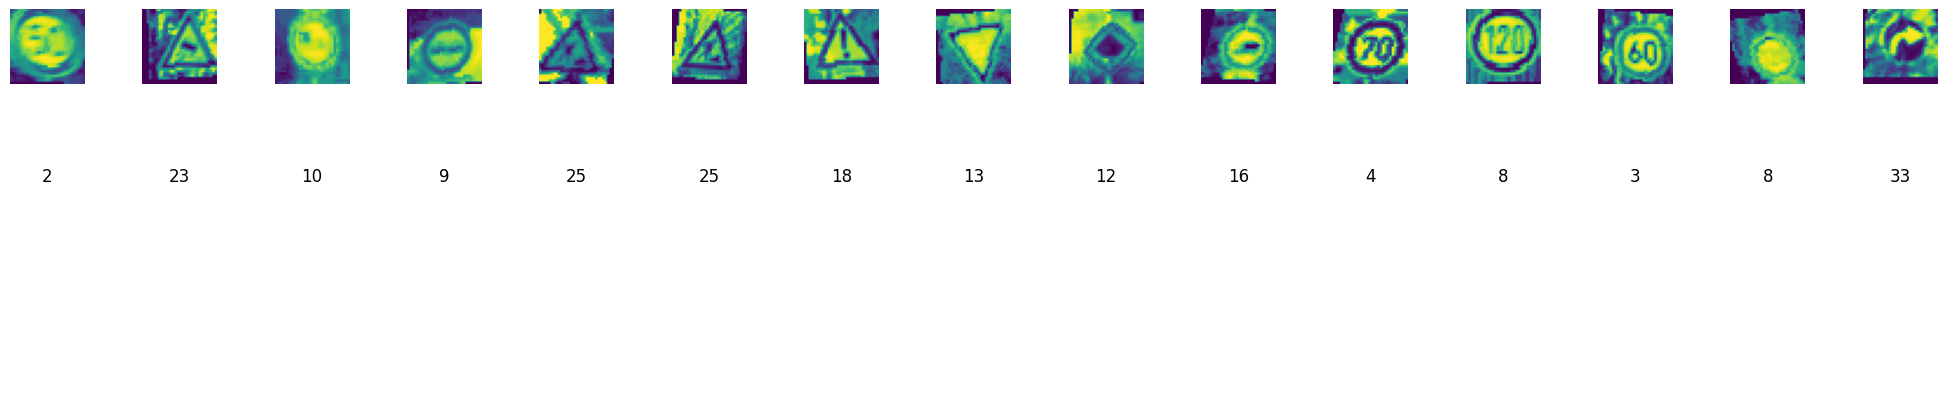

In [12]:
fig,axs=plt.subplots(2,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[0][i].imshow(X_train_dataset[i][0].numpy().reshape(32,32,1))
    axs[1][i].set_title(X_train_dataset[i][1])
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.show()

In [13]:
class MyModel(nn.Module):
    def __init__(self,input_shape,num_classes):
        super(MyModel, self).__init__()
        no_of_filters = 60
        size_of_filter = (5,5)
        size_of_filter2 = (3,3)
        size_of_pool = (2,2)
        no_of_nodes = 500

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_of_filters, kernel_size = size_of_filter)
        self.conv2 = nn.Conv2d(in_channels = no_of_filters, out_channels = no_of_filters, kernel_size = size_of_filter)
        self.pool1 = nn.MaxPool2d(kernel_size = size_of_pool)

        self.conv3 = nn.Conv2d(in_channels = no_of_filters, out_channels = no_of_filters//2, kernel_size = size_of_filter2)
        self.conv4 = nn.Conv2d(in_channels = no_of_filters//2, out_channels = no_of_filters//2, kernel_size = size_of_filter2)
        self.pool2 = nn.MaxPool2d(kernel_size = size_of_pool)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(self.get_flatten_shape(input_shape), no_of_nodes)
        self.fc2 = nn.Linear(no_of_nodes, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def get_flatten_shape(self, input_shape):
        dummy_input = torch.zeros(1, 1, input_shape[2], input_shape[3])
        x = self.pool1(self.conv2(self.conv1(dummy_input)))
        x = self.pool2(self.conv4(self.conv3(x)))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)

        x = F.relu(self.fc1(self.flat(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
input_shape = X_train_dataset[0][0].shape
num_classes = no_of_classes
model = MyModel(input_shape=[1,1,32,32], num_classes=num_classes).to(device)
model

MyModel(
  (conv1): Conv2d(1, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(60, 60, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(60, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:
img_batch, label_batch = next(iter(X_train_loader))
print(f"Image batch shape: {img_batch.shape}\n")
print(f"Label batch shape: {label_batch.shape}")
# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4.convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Image batch shape: torch.Size([20, 1, 32, 32])

Label batch shape: torch.Size([20])
Single image shape: torch.Size([1, 1, 32, 32])

Output logits:
tensor([[ 0.0051,  0.0107,  0.0043,  0.0274,  0.0272, -0.0041, -0.0096,  0.0382,
         -0.0448,  0.0151, -0.0358,  0.0323, -0.0158, -0.0230, -0.0119, -0.0234,
         -0.0239, -0.0166, -0.0091,  0.0318, -0.0452,  0.0252, -0.0252, -0.0118,
          0.0425,  0.0588, -0.0638,  0.0083, -0.0297, -0.0050,  0.0354, -0.0092,
         -0.0328,  0.0085,  0.0193,  0.0098,  0.0388, -0.0069,  0.0277, -0.0259,
         -0.0472,  0.0220,  0.0183]])

Output prediction probabilities:
tensor([[0.0234, 0.0235, 0.0234, 0.0239, 0.0239, 0.0232, 0.0230, 0.0242, 0.0222,
         0.0236, 0.0224, 0.0240, 0.0229, 0.0227, 0.0230, 0.0227, 0.0227, 0.0229,
         0.0230, 0.0240, 0.0222, 0.0238, 0.0227, 0.0230, 0.0243, 0.0247, 0.0218,
         0.0234, 0.0226, 0.0231, 0.0241, 0.0230, 0.0225, 0.0235, 0.0237, 0.0235,
         0.0242, 0.0231, 0.0239, 0.0227, 0.0222, 0.0

In [16]:
summary(model, input_size = [1,1,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 43]                   --
├─Conv2d: 1-1                            [1, 60, 28, 28]           1,560
├─Conv2d: 1-2                            [1, 60, 24, 24]           90,060
├─MaxPool2d: 1-3                         [1, 60, 12, 12]           --
├─Conv2d: 1-4                            [1, 30, 10, 10]           16,230
├─Conv2d: 1-5                            [1, 30, 8, 8]             8,130
├─MaxPool2d: 1-6                         [1, 30, 4, 4]             --
├─Dropout: 1-7                           [1, 30, 4, 4]             --
├─Flatten: 1-8                           [1, 480]                  --
├─Linear: 1-9                            [1, 500]                  240,500
├─Dropout: 1-10                          [1, 500]                  --
├─Linear: 1-11                           [1, 43]                   21,543
Total params: 378,023
Trainable params: 378,023
Non-trainable 

In [17]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [18]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [19]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [20]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr=0.001)

# pickle_in=open("model_trained.p","rb")
# model=pickle.load(pickle_in)



In [33]:
results = train(model = model, train_dataloader=X_train_loader, test_dataloader=X_val_loader,optimizer = optimizer, loss_fn=loss_fn,epochs=15)

  7%|▋         | 1/15 [00:58<13:39, 58.52s/it]

Epoch: 1 | train_loss: 0.3373 | train_acc: 0.8969 | test_loss: 0.1711 | test_acc: 0.9460


 13%|█▎        | 2/15 [01:58<12:53, 59.47s/it]

Epoch: 2 | train_loss: 0.3428 | train_acc: 0.8924 | test_loss: 0.1638 | test_acc: 0.9516


 20%|██        | 3/15 [02:59<12:03, 60.32s/it]

Epoch: 3 | train_loss: 0.3438 | train_acc: 0.8929 | test_loss: 0.1604 | test_acc: 0.9490


 27%|██▋       | 4/15 [04:02<11:13, 61.24s/it]

Epoch: 4 | train_loss: 0.3472 | train_acc: 0.8921 | test_loss: 0.1661 | test_acc: 0.9488


 33%|███▎      | 5/15 [05:03<10:12, 61.24s/it]

Epoch: 5 | train_loss: 0.3410 | train_acc: 0.8949 | test_loss: 0.1663 | test_acc: 0.9483


 40%|████      | 6/15 [06:11<09:30, 63.43s/it]

Epoch: 6 | train_loss: 0.3424 | train_acc: 0.8927 | test_loss: 0.1723 | test_acc: 0.9466


 47%|████▋     | 7/15 [07:12<08:20, 62.54s/it]

Epoch: 7 | train_loss: 0.3435 | train_acc: 0.8923 | test_loss: 0.1702 | test_acc: 0.9489


 53%|█████▎    | 8/15 [08:16<07:22, 63.22s/it]

Epoch: 8 | train_loss: 0.3417 | train_acc: 0.8920 | test_loss: 0.1639 | test_acc: 0.9504


 60%|██████    | 9/15 [09:20<06:20, 63.34s/it]

Epoch: 9 | train_loss: 0.3524 | train_acc: 0.8888 | test_loss: 0.1586 | test_acc: 0.9551


 67%|██████▋   | 10/15 [10:27<05:21, 64.34s/it]

Epoch: 10 | train_loss: 0.3374 | train_acc: 0.8947 | test_loss: 0.1604 | test_acc: 0.9518


 73%|███████▎  | 11/15 [11:29<04:15, 63.76s/it]

Epoch: 11 | train_loss: 0.3433 | train_acc: 0.8917 | test_loss: 0.1671 | test_acc: 0.9536


 80%|████████  | 12/15 [12:32<03:10, 63.58s/it]

Epoch: 12 | train_loss: 0.3487 | train_acc: 0.8931 | test_loss: 0.1591 | test_acc: 0.9541


 87%|████████▋ | 13/15 [13:36<02:07, 63.56s/it]

Epoch: 13 | train_loss: 0.3339 | train_acc: 0.8941 | test_loss: 0.1629 | test_acc: 0.9499


 93%|█████████▎| 14/15 [14:39<01:03, 63.35s/it]

Epoch: 14 | train_loss: 0.3394 | train_acc: 0.8931 | test_loss: 0.1673 | test_acc: 0.9523


100%|██████████| 15/15 [15:48<00:00, 63.23s/it]

Epoch: 15 | train_loss: 0.3343 | train_acc: 0.8923 | test_loss: 0.1690 | test_acc: 0.9483


In [34]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

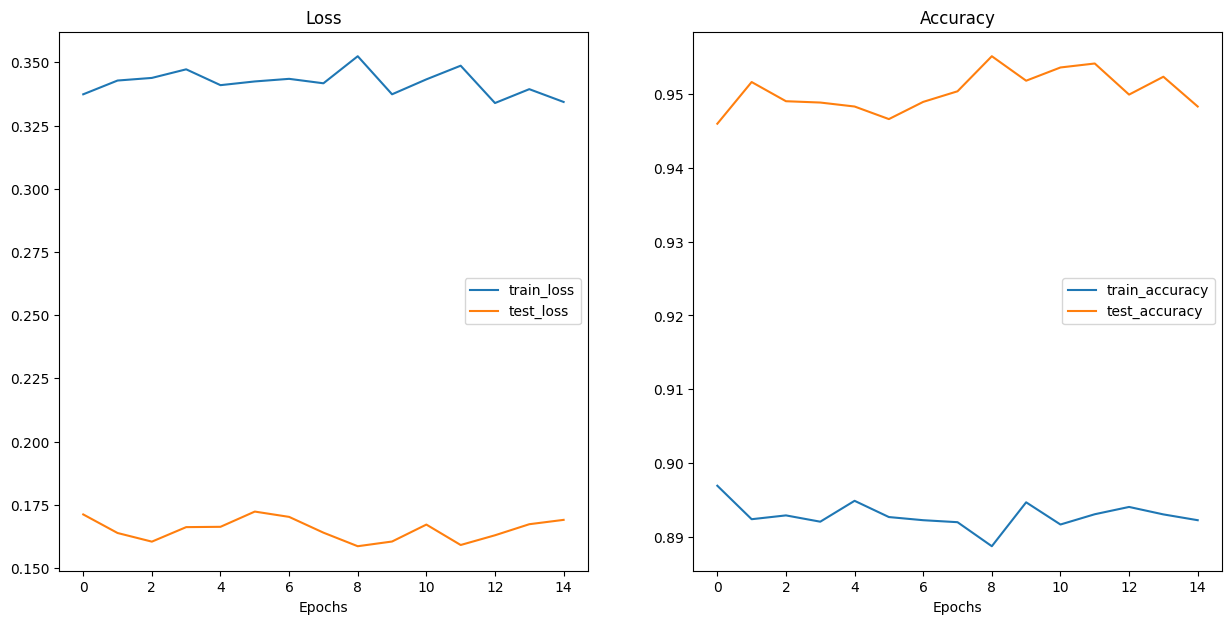

In [35]:
plot_loss_curves(results)

Save and Test the model

In [36]:
torch.save(model.state_dict(), "model_trained.pth")
cv2.waitKey(0)

-1

In [37]:
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.9        # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [46]:
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)
# IMPORT THE TRANNIED MODEL
model = MyModel(input_shape=[1,1,32,32], num_classes=num_classes).to(device)
model.load_state_dict(torch.load("model_trained.pth", map_location=device))
model.to(device)
model.eval()

C:\Users\yash jain\AppData\Local\Temp\ipykernel_18140\3139493070.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_trained.pth", ma

MyModel(
  (conv1): Conv2d(1, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(60, 60, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(60, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [47]:
def getClassName(classNo):
  if   classNo == 0: return 'Speed Limit 20 km/h'
  elif classNo == 1: return 'Speed Limit 30 km/h'
  elif classNo == 2: return 'Speed Limit 50 km/h'
  elif classNo == 3: return 'Speed Limit 60 km/h'
  elif classNo == 4: return 'Speed Limit 70 km/h'
  elif classNo == 5: return 'Speed Limit 80 km/h'
  elif classNo == 6: return 'End of Speed Limit 80 km/h'
  elif classNo == 7: return 'Speed Limit 100 km/h'
  elif classNo == 8: return 'Speed Limit 120 km/h'
  elif classNo == 9: return 'No passing'
  elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
  elif classNo == 11: return 'Right-of-way at the next intersection'
  elif classNo == 12: return 'Priority road'
  elif classNo == 13: return 'Yield'
  elif classNo == 14: return 'Stop'
  elif classNo == 15: return 'No vechiles'
  elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
  elif classNo == 17: return 'No entry'
  elif classNo == 18: return 'General caution'
  elif classNo == 19: return 'Dangerous curve to the left'
  elif classNo == 20: return 'Dangerous curve to the right'
  elif classNo == 21: return 'Double curve'
  elif classNo == 22: return 'Bumpy road'
  elif classNo == 23: return 'Slippery road'
  elif classNo == 24: return 'Road narrows on the right'
  elif classNo == 25: return 'Road work'
  elif classNo == 26: return 'Traffic signals'
  elif classNo == 27: return 'Pedestrians'
  elif classNo == 28: return 'Children crossing'
  elif classNo == 29: return 'Bicycles crossing'
  elif classNo == 30: return 'Beware of ice/snow'
  elif classNo == 31: return 'Wild animals crossing'
  elif classNo == 32: return 'End of all speed and passing limits'
  elif classNo == 33: return 'Turn right ahead'
  elif classNo == 34: return 'Turn left ahead'
  elif classNo == 35: return 'Ahead only'
  elif classNo == 36: return 'Go straight or right'
  elif classNo == 37: return 'Go straight or left'
  elif classNo == 38: return 'Keep right'
  elif classNo == 39: return 'Keep left'
  elif classNo == 40: return 'Roundabout mandatory'
  elif classNo == 41: return 'End of no passing'
  elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

In [48]:
while True:
    success, imgOriginal = cap.read()
    if not success:
        print("Error: Could not read frame from camera.")
        break

    img = cv2.resize(imgOriginal, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 1, 32, 32)
    img = torch.from_numpy(img).float().to(device)

    with torch.inference_mode():
        outputs = model(img)
        classIndex = torch.argmax(outputs, dim=1).item()
        probabilityValue = torch.max(torch.softmax(outputs, dim=1)).item()

    cv2.putText(imgOriginal, "CLASS:", (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOriginal, "PROBABILITY:", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    if probabilityValue > threshold:
        cv2.putText(imgOriginal, f"{classIndex} {getClassName(classIndex)}", (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(imgOriginal, f"{round(probabilityValue * 100, 2)}%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Result", imgOriginal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()